In [10]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 82.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.1 MB/s eta 0:00:00


In [11]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=3f7e705f8d59a824244f1045298fc5a6ba802cf1584c91fdbd5afd6214e305a1
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, Trainer, TrainingArguments, AutoModelForSequenceClassification
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from underthesea import word_tokenize

plt.style.use('ggplot')

import nltk

Prepare data


In [14]:
df = pd.read_csv('/kaggle/input/comments-dataset/comments.csv')
print(df.shape)


(5650, 7)


In [34]:
import pandas as pd
from langdetect import detect

# Đọc dữ liệu (giả sử file CSV có cột 'comment' chứa văn bản)
df = pd.read_csv("/kaggle/input/comments-dataset/comments.csv")

# Hàm xác định ngôn ngữ
def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return "unknown"

# Áp dụng hàm để xác định ngôn ngữ
df["language"] = df["description"].apply(detect_language)

# Chia dữ liệu thành tiếng Việt và tiếng Anh
df_vi = df[df["language"] == "vi"]
df_en = df[df["language"] == "en"]

# Lưu lại thành các file riêng biệt
df_vi.to_csv("comments_vi.csv", index=False)
df_en.to_csv("comments_en.csv", index=False)

print(f"Số lượng comment tiếng Việt: {len(df_vi)}")
print(f"Số lượng comment tiếng Anh: {len(df_en)}")


Số lượng comment tiếng Việt: 5579
Số lượng comment tiếng Anh: 34


Xử lý tiếng việt


In [36]:
df_vi = pd.read_csv('comments_vi.csv')
print(df_vi.shape)

(5579, 8)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5579 entries, 0 to 5578
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             5579 non-null   object 
 1   userId          5579 non-null   object 
 2   restaurantId    5579 non-null   object 
 3   rate            5579 non-null   float64
 4   time            5579 non-null   object 
 5   title           5579 non-null   object 
 6   description     5579 non-null   object 
 7   language        5579 non-null   object 
 8   sentiment       5579 non-null   object 
 9   cleaned_text    5579 non-null   object 
 10  processed_text  5579 non-null   object 
 11  review_length   5579 non-null   int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 523.2+ KB
Missing values:
 _id               0
userId            0
restaurantId      0
rate              0
time              0
title             0
description       0
language          0
sentiment         0
c

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


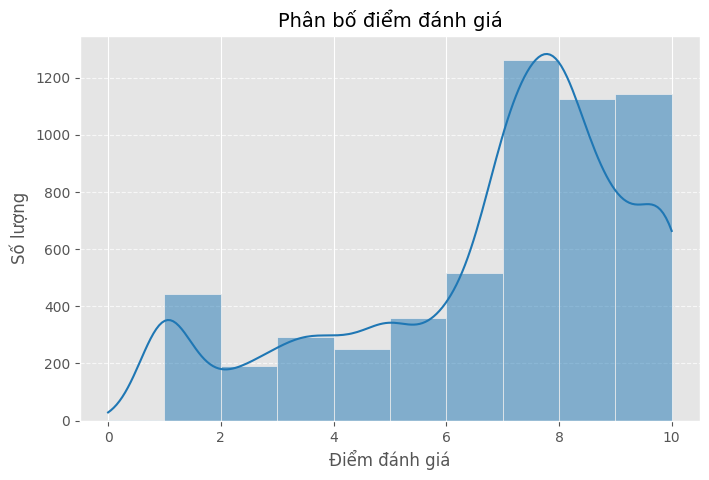

sentiment
positive    3917
negative     961
neutral      701
Name: count, dtype: int64


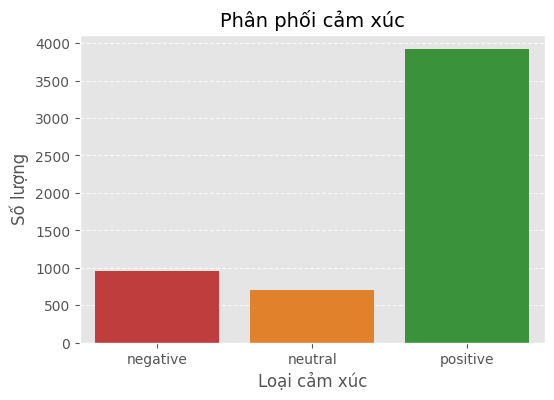

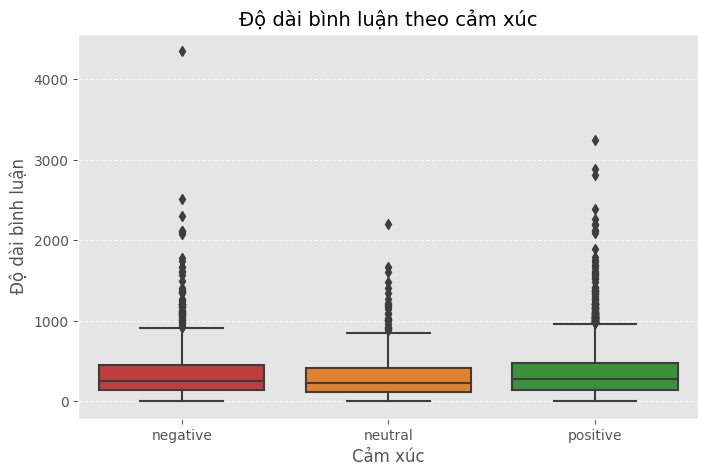

In [67]:
# Kiểm tra thông tin dữ liệu
df_vi.info()

# Kiểm tra dữ liệu bị thiếu
missing_values = df_vi.isnull().sum()
print("Missing values:\n", missing_values)

# Hiển thị thống kê mô tả của điểm đánh giá
print(df_vi['rate'].describe())

# Vẽ biểu đồ phân bố điểm đánh giá
plt.figure(figsize=(8, 5))
sns.histplot(df_vi['rate'], bins=10, kde=True, color='#1f77b4')  # Màu xanh đậm
plt.title('Phân bố điểm đánh giá', fontsize=14)
plt.xlabel('Điểm đánh giá', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Chuyển đổi điểm đánh giá thành cảm xúc
def convert_rating_to_label(rating):
    if rating <= 4:
        return "negative"
    elif rating <= 6:
        return "neutral"
    else:
        return "positive"

df_vi["sentiment"] = df_vi["rate"].apply(convert_rating_to_label)
print(df_vi["sentiment"].value_counts())

# Vẽ biểu đồ phân phối cảm xúc với màu sắc nổi bật
plt.figure(figsize=(6, 4))
sns.countplot(data=df_vi, x='sentiment', palette=['#d62728', '#ff7f0e', '#2ca02c'])  # Đỏ, cam, xanh lá
plt.title('Phân phối cảm xúc', fontsize=14)
plt.xlabel('Loại cảm xúc', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tính độ dài của mỗi bình luận
df_vi['review_length'] = df_vi['description'].astype(str).apply(len)

# So sánh độ dài bình luận giữa các nhóm cảm xúc
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_vi, x='sentiment', y='review_length', palette=['#d62728', '#ff7f0e', '#2ca02c'])
plt.title('Độ dài bình luận theo cảm xúc', fontsize=14)
plt.xlabel('Cảm xúc', fontsize=12)
plt.ylabel('Độ dài bình luận', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [39]:
# Chuyển đổi rating thành 3 lớp cảm xúc
def convert_rating_to_label(rating):
    if rating <= 4:
        return "negative"
    elif rating <= 6:
        return "neutral"
    else:
        return "positive"

In [41]:
df_vi["sentiment"] = df_vi["rate"].apply(convert_rating_to_label)

In [42]:
df_vi.head()

,_id,userId,restaurantId,rate,time,title,description,language,sentiment
0,678136022e6c6fe7a4d962d5,67812080426d11b58b7f04cb,67812ec1514dba6089ed92ac,3.0,28/6/2024 15:07,Cua quá dỡ,"Mua hộp cơm xào cua ăn mà thấy cua ko dc tươi,...",vi,negative
1,678136022e6c6fe7a4d962d6,67812080426d11b58b7f0524,67812ec1514dba6089ed92ac,1.0,14/1/2024 18:41,"đồ ăn rất tệ , không biêt có đúng tiệm không? ...",Dồ ăn quá tệ,vi,negative
2,678136022e6c6fe7a4d962d7,67812080426d11b58b7f0412,67812ec1514dba6089ed92ac,6.0,9/10/2023 18:54,Miến Cua 94 - Chính Gốc,Cơm xào cua nhiều cua ngon đáng tiền,vi,neutral
3,678136022e6c6fe7a4d962d8,67812080426d11b58b7f060a,67812ec1514dba6089ed92ac,9.4,8/8/2022 22:15,Miến Cua 94 - Chính Gốc,"Nhìn quán khá hấp dẫn, có dịp mình sẽ ghé lại ...",vi,positive
4,678136022e6c6fe7a4d962d9,67812080426d11b58b7f062c,67812ec1514dba6089ed92ac,7.0,22/9/2021 9:55,Chả giò mùa dịch,Sau 1 thời gian giãn cách mình đặt món tại tiệ...,vi,positive


Tokenization PhoBert


In [43]:
# Load PhoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [44]:
# Xử lý stopwords
stopwords = {"a", "à", "á", "ai", "anh", "bạn", "bởi", "cả", "cái", "các", "có", "cùng", "cứ", "của", "cũng", "dưới", "đã", "đang", "đây", "đành", "để", "đến", "đó", "đây", "đấy"}
def remove_stopwords(text):
    words = word_tokenize(text, format="text").split()
    return " ".join([word for word in words if word not in stopwords])

In [45]:
# Xử lý phủ định
def handle_negation(text):
    words = text.split()
    negations = {
        "không", "chưa", "chẳng", "chả", "đừng", "không hề", "đâu có",
        "chẳng hề", "chẳng bao giờ", "không phải", "không bao giờ",
        "không đời nào", "đâu phải", "đâu có phải", "không bao giờ có", "không thể nào",
        "không thể", "không dễ", "chẳng thể", "đâu có thể", "đâu dễ", "không cách nào",
        "không dám", "không nên", "không được", "không muốn", "đâu cần",
        "không cần", "chưa cần", "không mong", "không ước", "chẳng thích",
        "không có", "đâu có", "không còn", "chưa có", "chẳng có", "đâu còn",
        "không đáng", "chẳng đáng", "đâu đáng", "không hợp", "không đúng",
        "chẳng đúng", "chưa chắc", "không thích hợp", "chẳng phù hợp",
        "không đủ", "chưa đủ", "đâu đủ", "không đạt", "chưa đạt", "không tương xứng",
        "chưa từng", "chưa bao giờ", "không khi nào", "không một lần nào", "đâu có lúc nào",
        "không vui", "không hài lòng", "không hạnh phúc", "không thoải mái",
        "không phải lỗi của tôi", "đâu có lỗi", "không liên quan", "chẳng phải do tôi",
        "không đúng sự thật", "không phải sự thật", "không có chứng cứ",
        "không chắc chắn", "chưa chắc đúng", "chưa khẳng định",
        "không có gì thay đổi", "không hề thay đổi", "không cải thiện",
        "không đảm bảo", "không cam kết", "không chắc đâu",
    }
    processed_words = []
    skip = False
    for i in range(len(words)):
        if skip:
            skip = False
            continue
        if words[i] in negations and i < len(words) - 1:
            processed_words.append(words[i] + "_" + words[i + 1])
            skip = True
        else:
            processed_words.append(words[i])
    return " ".join(processed_words)


In [46]:
# Tiền xử lý văn bản
df_vi["cleaned_text"] = df_vi["description"].apply(remove_stopwords)
df_vi["processed_text"] = df_vi["cleaned_text"].apply(handle_negation)

In [47]:
df_vi.head()

,_id,userId,restaurantId,rate,time,title,description,language,sentiment,cleaned_text,processed_text
0,678136022e6c6fe7a4d962d5,67812080426d11b58b7f04cb,67812ec1514dba6089ed92ac,3.0,28/6/2024 15:07,Cua quá dỡ,"Mua hộp cơm xào cua ăn mà thấy cua ko dc tươi,...",vi,negative,Mua hộp cơm xào cua ăn mà thấy cua ko dc tươi ...,Mua hộp cơm xào cua ăn mà thấy cua ko dc tươi ...
1,678136022e6c6fe7a4d962d6,67812080426d11b58b7f0524,67812ec1514dba6089ed92ac,1.0,14/1/2024 18:41,"đồ ăn rất tệ , không biêt có đúng tiệm không? ...",Dồ ăn quá tệ,vi,negative,Dồ ăn quá tệ,Dồ ăn quá tệ
2,678136022e6c6fe7a4d962d7,67812080426d11b58b7f0412,67812ec1514dba6089ed92ac,6.0,9/10/2023 18:54,Miến Cua 94 - Chính Gốc,Cơm xào cua nhiều cua ngon đáng tiền,vi,neutral,Cơm xào_cua nhiều cua ngon_đáng tiền,Cơm xào_cua nhiều cua ngon_đáng tiền
3,678136022e6c6fe7a4d962d8,67812080426d11b58b7f060a,67812ec1514dba6089ed92ac,9.4,8/8/2022 22:15,Miến Cua 94 - Chính Gốc,"Nhìn quán khá hấp dẫn, có dịp mình sẽ ghé lại ...",vi,positive,"Nhìn quán khá hấp_dẫn , dịp mình sẽ ghé lại qu...","Nhìn quán khá hấp_dẫn , dịp mình sẽ ghé lại qu..."
4,678136022e6c6fe7a4d962d9,67812080426d11b58b7f062c,67812ec1514dba6089ed92ac,7.0,22/9/2021 9:55,Chả giò mùa dịch,Sau 1 thời gian giãn cách mình đặt món tại tiệ...,vi,positive,Sau 1 thời_gian giãn cách mình đặt món tại tiệ...,Sau 1 thời_gian giãn cách mình đặt món tại tiệ...


In [48]:
# Tokenization với truncation & padding
tokenized_data = tokenizer.batch_encode_plus(
    df_vi["processed_text"].tolist(),
    padding="max_length",  # Luôn đảm bảo cùng độ dài
    truncation=True,       # Cắt bớt câu quá dài
    max_length=256,        # Giới hạn độ dài tối đa
    return_tensors="pt"
)

In [51]:
# Chuyển đổi nhãn
labels = torch.tensor(df_vi["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).values, dtype=torch.long)


<ipython-input-51-844a58cd8754>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels = torch.tensor(df_vi["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).infer_objects().values, dtype=torch.long)


In [53]:
# Chia dữ liệu train & eval
train_inputs, eval_inputs, train_labels, eval_labels = train_test_split(
    tokenized_data["input_ids"], labels, test_size=0.2, random_state=42
)
train_masks, eval_masks = train_test_split(tokenized_data["attention_mask"], test_size=0.2, random_state=42)


In [54]:
# Dataset mới
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

In [55]:
# Tạo dataset
train_dataset = SentimentDataset(train_inputs, train_masks, train_labels)
eval_dataset = SentimentDataset(eval_inputs, eval_masks, eval_labels)


In [56]:
# Data collator để padding tự động
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [57]:
# Cấu hình training
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
)

# Load mô hình PhoBERT
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=3)

# Huấn luyện với Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Bắt đầu huấn luyện
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.544400,0.640822
2,0.456800,0.360084
3,0.343700,0.426262


TrainOutput(global_step=1674, training_loss=0.4788088621916594, metrics={'train_runtime': 403.6581, 'train_samples_per_second': 33.169, 'train_steps_per_second': 4.147, 'total_flos': 1761412774980096.0, 'train_loss': 0.4788088621916594, 'epoch': 3.0})

In [58]:
import torch
from sklearn.metrics import classification_report, accuracy_score
from transformers import Trainer

# Hàm tính toán các metrics chi tiết
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=1)  # Lấy nhãn có xác suất cao nhất từ logits
    accuracy = accuracy_score(labels, predictions)  # Accuracy
    
    # Các metrics khác: Precision, Recall, F1
    report = classification_report(labels, predictions, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Tạo Trainer với compute_metrics để tính toán các metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Sử dụng hàm compute_metrics
)

# Đánh giá mô hình
results = trainer.evaluate()

# In kết quả chi tiết
print("Evaluation Results:")
print(f"Loss: {results['eval_loss']}")
print(f"Accuracy: {results['eval_accuracy']}")
print(f"Precision: {results['eval_precision']}")
print(f"Recall: {results['eval_recall']}")
print(f"F1-Score: {results['eval_f1']}")

# Nếu bạn muốn lưu kết quả vào một file
with open("evaluation_results.txt", "w") as f:
    f.write(f"Loss: {results['eval_loss']}\n")
    f.write(f"Accuracy: {results['eval_accuracy']}\n")
    f.write(f"Precision: {results['eval_precision']}\n")
    f.write(f"Recall: {results['eval_recall']}\n")
    f.write(f"F1-Score: {results['eval_f1']}\n")


Evaluation Results:
Loss: 0.4262615442276001
Accuracy: 0.8530465949820788
Precision: 0.8502947314236482
Recall: 0.8530465949820788
F1-Score: 0.851615168483619


In [59]:
import torch

def predict_sentiment(comment):
    model.eval()  # Chuyển model sang chế độ đánh giá (inference)

    # Tiền xử lý: Loại bỏ stopwords và xử lý phủ định
    cleaned_comment = remove_stopwords(comment)
    processed_comment = handle_negation(cleaned_comment)

    # Tokenize câu mới
    encoded_comment = tokenizer(
        processed_comment,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )

    # Chuyển dữ liệu vào GPU nếu có
    input_ids = encoded_comment["input_ids"].to("cuda" if torch.cuda.is_available() else "cpu")
    attention_mask = encoded_comment["attention_mask"].to("cuda" if torch.cuda.is_available() else "cpu")

    # Dự đoán
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(torch.nn.functional.softmax(logits, dim=-1), dim=-1).cpu().numpy()[0]

    # Gán nhãn cảm xúc
    labels = {0: "Tiêu cực", 1: "Trung lập", 2: "Tích cực"}
    return labels[prediction]


In [8]:
# #get model

# from transformers import AutoModel
# from safetensors.torch import load_file

# # Định nghĩa đường dẫn file
# model_path = "/kaggle/input/sentiment-analysis/other/default/1/model.safetensors"

# # Nạp trọng số vào mô hình
# model = AutoModel.from_pretrained("vinai/phobert-base")
# state_dict = load_file(model_path)
# model.load_state_dict(state_dict, strict=False)


# print("Mô hình đã được tải thành công!")


Mô hình đã được tải thành công!


In [60]:
comment = "Cơm xào cua nhiều cua ngon đáng tiền"
result = predict_sentiment(comment)
print(f"Comment: {comment} --> Sentiment: {result}")


Comment: Cơm xào cua nhiều cua ngon đáng tiền --> Sentiment: Trung lập


In [61]:
model.save_pretrained("./phobert_sentiment")
tokenizer.save_pretrained("./phobert_sentiment")


('./phobert_sentiment/tokenizer_config.json',
 './phobert_sentiment/special_tokens_map.json',
 './phobert_sentiment/vocab.txt',
 './phobert_sentiment/bpe.codes',
 './phobert_sentiment/added_tokens.json')